# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os

In [2]:
file_name = 'camera_cal'
path = os.listdir(file_name)


# prepare object points
(nx, ny) = (9, 6)
img_points = []
obj_points = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for name in path:
    # Make a list of calibration images
    img = cv2.imread(file_name + '/' + name)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        # append the points set
        img_points.append(corners)
        obj_points.append(objp)
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        #plt.imshow(img)
        #plt.show()


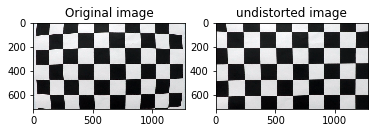

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    undist = np.copy(img)  
    img_size = (undist.shape[0],undist.shape[1])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(undist, mtx, dist, None, mtx)
    return undist

img = cv2.imread(file_name + '/' + 'calibration1.jpg')
undistorted = cal_undistort(img, obj_points, img_points)
plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undistorted)
plt.show()

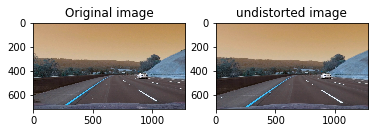

In [4]:
img = cv2.imread('test_images/test3.jpg')
undist = cal_undistort(img, obj_points, img_points)
plt.figure()
plt.subplot(1,2,1)
plt.title('Original image')
plt.imshow(img)
plt.subplot(1,2,2)
plt.title('undistorted image')
plt.imshow(undist)
plt.show()

# Define necessary function

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F,1,0,ksize = sobel_kernel))
    scaled_sobel = np.uint8(255*sobelx/np.max(sobelx))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def rgb_thresh(img, channel = 'r', thresh = (0,255)):
    if channel == 'g':
        ch = 1
    elif channel == 'b':
        ch = 0
    else:
        ch = 2
    channel_img = img[:,:,ch]
    rgb_binary = np.zeros_like(channel_img)
    rgb_binary[(channel_img >= thresh[0]) & (channel_img <= thresh[1])] = 1
    return rgb_binary

def hls_thresh(img, channel = 's',thresh=(0, 255)):
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    if channel == 'h':
        ch = 0
    elif channel == 'l':
        ch = 1
    else:
        ch = 2
    channel_img = hls[:,:,ch]
    hls_binary = np.zeros_like(channel_img)
    hls_binary[(channel_img >= thresh[0]) & (channel_img <= thresh[1])] = 1
    return hls_binary

def hsv_thresh(img, channel = 'h',thresh=(0, 255)):
    hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    if channel == 's':
        ch = 1
    elif channel == 'v':
        ch = 2
    else:
        ch = 0
    channel_img = hsv[:,:,ch]
    hsv_binary = np.zeros_like(channel_img)
    hsv_binary[(hsv_binary > thresh[0]) & (hsv_binary <= thresh[1])] = 1
    return hsv_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    abs_Sobel = np.sqrt(sobelx**2+sobely**2)
    scale_factor = np.max(abs_Sobel)/255 
    scaled_sobel = (abs_Sobel/scale_factor).astype(np.uint8)
    # Apply threshold
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
   # Calculate gradient magnitude
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel))
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    # Apply threshold
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return dir_binary

def combine_rgb_thresh(img, r = (0,255), g = (0,255), b = (0,255)):
    rgb = cv2.GaussianBlur(img,(5,5),2.0)
    channel_r = rgb_thresh(rgb,'r',r)
    channel_g = rgb_thresh(rgb,'g',g)    
    channel_b = rgb_thresh(rgb,'b',b)
    rgb_binary = np.zeros_like(channel_r)
    rgb_binary[(channel_r == 1)&(channel_g == 1)&(channel_b == 1)] = 1
    return rgb_binary

def combine_hls_thresh(img, h = (0,255), l = (0,255), s = (0,255)):
    hls = cv2.GaussianBlur(img,(5,5),2.0)
    channel_h = hls_thresh(hls,'h',h)
    channel_l = hls_thresh(hls,'l',l)    
    channel_s = hls_thresh(hls,'s',s)
    hls_binary = np.zeros_like(channel_h)
    hls_binary[(channel_h == 1)&(channel_l == 1)&(channel_s == 1)] = 1
    return hls_binary

def combine_hsv_thresh(img, h = (0,255), s = (0,255), v = (0,255)):
    hsv = cv2.GaussianBlur(img,(5,5),2.0)
    channel_h = hsv_thresh(hsv,'h',h)
    channel_s = hsv_thresh(hsv,'s',s)    
    channel_v = hsv_thresh(hsv,'v',v)
    hsv_binary = np.zeros_like(channel_h)
    hsv_binary[(channel_h == 1)&(channel_s == 1)&(channel_v == 1)] = 1
    return hsv_binary

# Method I: Use build-in function

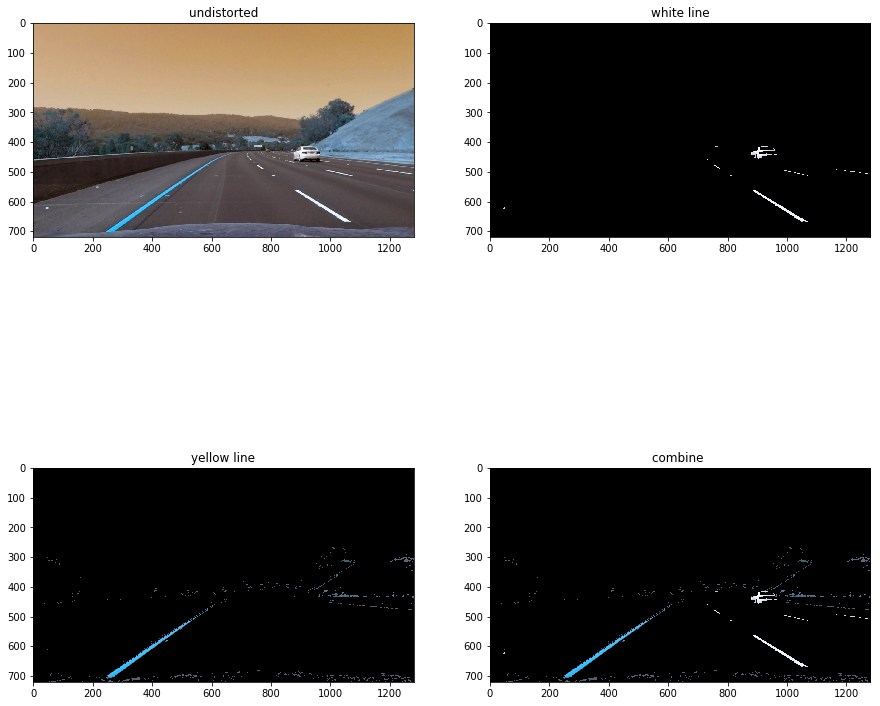

In [6]:
mask_white = cv2.inRange(undist, (180, 180, 210), (255, 255, 255))
## slice the white
imask = mask_white>0
white = np.zeros_like(undist, np.uint8)
white[imask] = undist[imask]
# BGR
mask_yellow = cv2.inRange(undist, (20, 90, 100), (90, 255, 255))
imask = mask_yellow>0
yellow = np.zeros_like(undist, np.uint8)
yellow[imask] = undist[imask]

mask = cv2.bitwise_or(mask_white, mask_yellow)
target = cv2.bitwise_and(undist,undist, mask=mask)


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('undistorted')
plt.imshow(undist)

plt.subplot(2,2,2)
plt.title('white line')
plt.imshow(white,cmap ='Greys_r')

plt.subplot(2,2,3)
plt.title('yellow line')
plt.imshow(yellow,cmap ='Greys_r')

plt.subplot(2,2,4)
plt.title('combine ')
plt.imshow(target,cmap ='Greys_r')


# Method II: Use pre-defined function

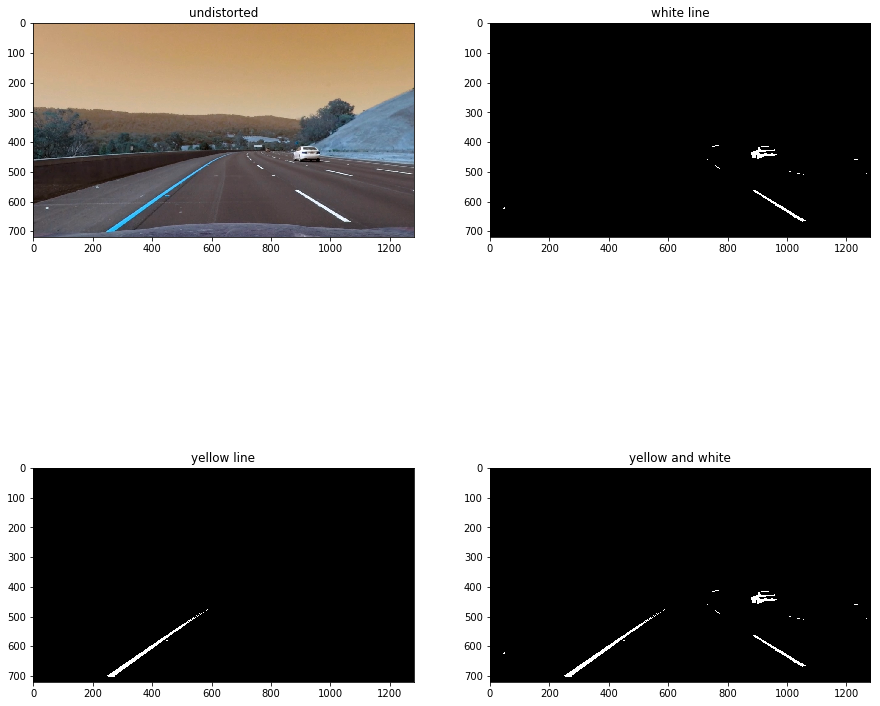

In [7]:
white_detect = combine_rgb_thresh(undist,r = (180,255),g = (180,255),b = (100,255))
yellow_detect = combine_rgb_thresh(undist,r = (170,255),g = (90,255),b = (20,90))
combine_white_yellow = np.zeros_like(white_detect)
combine_white_yellow[(white_detect == 1) | (yellow_detect == 1)] =1


plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('undistorted')
plt.imshow(undist)

plt.subplot(2,2,2)
plt.title('white line')
plt.imshow(white_detect,cmap ='Greys_r')

plt.subplot(2,2,3)
plt.title('yellow line')
plt.imshow(yellow_detect,cmap ='Greys_r')

plt.subplot(2,2,4)
plt.title('yellow and white')
plt.imshow(combine_white_yellow,cmap ='Greys_r')

# Undistort and Transform

Text(0.5,1,'warped')

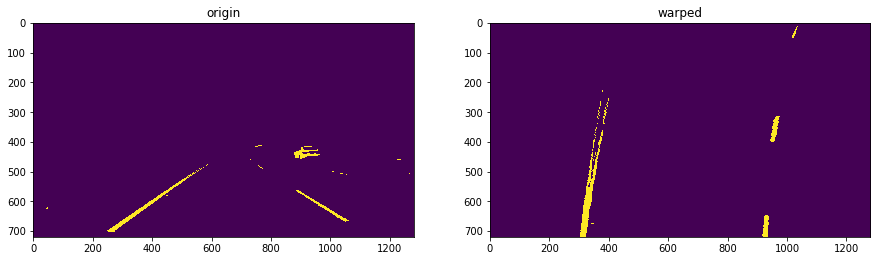

In [8]:
#src = np.float32([[220,690],[500,480],[700,480],[1133,690]])
#src = np.float32([[200,700],[400,400],[800,400],[1200,700]])
src = np.float32([[293,668],[587,458],[703,458],[1028,668]])

img_size = (undist.shape[1],img.shape[0])
#dst = np.float32([[0,img_size[1]],[0,0],[img_size[0],0],[img_size[0],img_size[1]]])
dst = np.float32([[300,750],[300,0],[900,0],[900,750]])

M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combine_white_yellow, M, img_size, flags=cv2.INTER_LINEAR)
plt.figure(figsize =(15,15))
plt.subplot(1,2,1)
plt.imshow(combine_white_yellow)
plt.title('origin')

plt.subplot(1,2,2)
plt.imshow(warped)
plt.title('warped')

# Finding the Lines: Sliding Window

In [56]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    output = np.dstack((binary_warped, binary_warped, binary_warped))
    output = 255*(np.uint8(output*255))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 55

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current  - margin   # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(output,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(output,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If found > minpix pixels, recenter next window 
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        ### (`right` or `leftx_current`) on their mean position ###
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    #alc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    output[lefty,leftx] = [255, 0, 0]
    output[righty,rightx] = [0, 0, 255]
    return left_fit, right_fit, ploty, output


In [57]:
left_fit, right_fit, ploty, output = find_lane_pixels(warped)
plt.figure(figsize=(15,15))
plt.imshow(output)
plt.plot(left_fitx, ploty)
plt.plot(right_fitx, ploty)
plt.xlim(0,1280)
# Not (0,720)
plt.ylim(720,0)

TypeError: 'tuple' object is not callable

# Calculate Curvature

In [38]:
def measure_curvature_real(left_fit,right_fit,img_size):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0,img_size[0]-1,num = img_size[0])    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    

    leftx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 +right_fit[1]*ploty + right_fit[2]
    
    # Fit a second order polynomial to pixel positions in each lane line
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    #Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    x_offset = (left_fit_cr[2] + right_fit_cr[2])/2 - img_size[1]* xm_per_pix/2
    y_offset = (left_fit_cr[2] + right_fit_cr[2])/2 - img_size[0]* ym_per_pix/2
    return left_curverad, right_curverad, x_offset, y_offset

def warp_perspective_back(img, warped,img_size,left_fit,right_fit):
    Minv = cv2.getPerspectiveTransform(dst, src)

    warp_zero = np.uint8(np.zeros_like(warped))
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0,img_size[0]-1,num = img_size[0])
    
    leftx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 +right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([leftx,ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx,ploty])))])
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts = np.hstack((pts_left,pts_right))
    # pts: array of polygons where each polygon is represented as an array of points.
    # cv2.fillPoly(img, pts, color[, lineType[, shift[, offset]]]) → img
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv,img_size) 
    
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [55]:
warp_zero = np.zeros_like(warped).astype(np.uint8)
print(warp_zero)



[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
720
1280


In [41]:
left_curverad, right_curverad, x_offset, y_offset = measure_curvature_real(left_fit,right_fit,img_size)
curvature = (left_curverad + right_curverad)/2
img = cv2.imread('test_images/test3.jpg')
result = warp_perspective_back(img, warped,img_size, left_fit, right_fit)


TypeError: 'tuple' object is not callable

In [ ]:
left_curverad, right_curverad, x_offset, y_offset = measure_curvature_real(left_fit,right_fit,img_size)
curvature = (left_curverad + right_curverad)/2
img = cv2.imread('test_images/test3.jpg')
result = warp_perspective_back(img, warped,img_size, left_fit, right_fit)
plt.figrue(figsize=(115,15))
plt.imshow(result)



In [46]:
warp_zero = np.uint8(np.zeros_like(warped))


In [47]:
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))


TypeError: 'tuple' object is not callable